In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import glikonal_mrap as mrap
import pyvista as pv
import matplotlib
from matplotlib.colors import LinearSegmentedColormap



## Point source test with constant wind and no terrain

In [2]:
H=101 
W=101
h=1 #grid spacing
hx=h
hy=h
g=1 #glide ratio
elevation=0*np.ones([H,W]) #elevation profile

#initial position and altitude of aircraft
init_pos=(H//2,W//2) #source position
init_altitude=0

In [3]:
#use the solver to obtain the approximate solution for the gliding range
radius=2.9 
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
grid=mrap.FMM_MRAP(init_nodes, init_values, elevation, h,g,H,W)
grid_chars=np.moveaxis(np.array(np.gradient(grid)),0,2)
grid_chars=-np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60749/1693192432.py:6: RuntimeWarning: divide by zero encountered in divide
  grid_chars=-np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))


In [4]:
#finding the true solution
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
true_grid=np.inf*np.ones([H,W])
true_grid_chars=np.zeros([H,W,2])
for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]


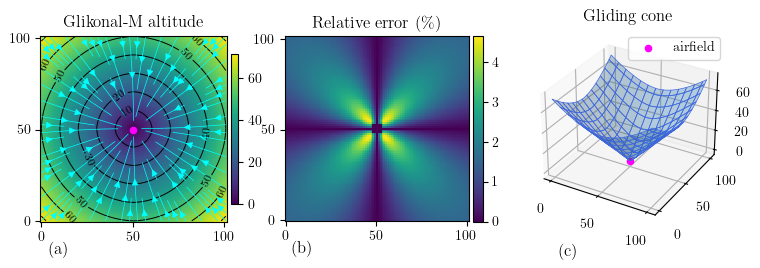

In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True})

fig,axes=plt.subplots(1,3,figsize=(7.4,3.4))
fig.tight_layout(pad=0.5)


ax=axes[0]
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))

im1=ax.pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=ax.contour(X,Y,grid,colors='k',linewidths=0.7)
ax.clabel(CS, fontsize=8, inline=True)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.8,color='aqua',linewidth=0.5)
ax.set_aspect('equal')
ax.set_title('Glikonal-M altitude')
ax.scatter(init_pos[1],init_pos[0],color="magenta",label="airfield",s=20)
fig.colorbar(im1,ax=ax,fraction=0.038, pad=0.02)

ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.text(0.1, -0.15, "(a)", ha='center', va='center', transform=ax.transAxes, fontsize=12)

grid2=np.copy(grid)
grid2[grid2==-np.inf]=0
grid2[grid2>0]=np.inf
grid2[0,0]=1



ax=axes[1]
grid_gained_altitude=grid-init_altitude
true_grid_gained_altitude=true_grid-init_altitude
rel_error=np.abs(grid_gained_altitude-true_grid_gained_altitude)/(true_grid_gained_altitude+1e-10)

im=ax.pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
#fig.colorbar(im,ax=ax)
#CS=ax.contour(X,Y,rel_error,colors='k')
#ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_title('Relative error (\%)')
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(im,ax=ax,fraction=0.047, pad=0.02)
ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.text(0.1, -0.15, "(b)", ha='center', va='center', transform=ax.transAxes, fontsize=12)



axes[2].remove()
#3D surface representing the gliding cone.
ax = fig.add_subplot(1,3,3,projection='3d')

ax.plot_surface(X,Y, grid, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)
ax.scatter(init_pos[1],init_pos[0],init_altitude,color="magenta",label="airfield",s=20)

plt.title("Gliding cone")
ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.text(x=0.1, y=-0.15, z=-90, s="(c)",fontsize=12)
ax.legend()
#ax.set_zticks([])


plt.savefig("pics/glikonal_mrap_flat.pdf", bbox_inches='tight', dpi=600)
plt.show()


## Example with single obstacle in the flight path

In [6]:
H=101 
W=101
h=1
hx=h
hy=h

center=(H//2,W//2)
yy,xx=np.meshgrid(np.arange(0,H,hy,dtype=np.intc),np.arange(0,W,hx,dtype=np.intc))
elevation=94*np.exp(-((xx-center[0])**2+(yy-center[1])**2)/510) #set the elevation profile


#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=0

In [7]:
#use the solver to obtain the approximate solution for the gliding range
radius=2.9 
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
grid=mrap.FMM_MRAP(init_nodes, init_values, elevation, h,g,H,W)
grid_chars=np.moveaxis(np.array(np.gradient(grid)),0,2)
grid_chars=-np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))


/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60749/4267413505.py:6: RuntimeWarning: divide by zero encountered in divide
  grid_chars=-np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))


/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60749/4105613471.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='white',label='aircraft')


Text(0.5, 1.0, 'glide range (shaded region) plotted on top of the elevation profile')

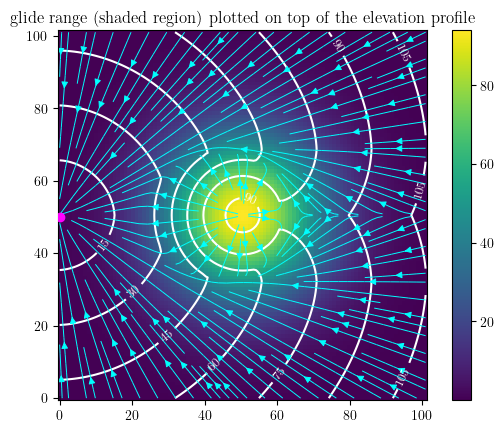

In [8]:
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,ax=plt.subplots()

pc=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
fig.colorbar(pc)
CS=ax.contour(X,Y,grid,colors='white',label='aircraft')
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=1.4,color='aqua',linewidth=0.7)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='magenta',label='aircraft',zorder=10000)

grid2=np.copy(grid)
grid2[grid2==-np.inf]=0
grid2[grid2>0]=np.inf
grid2[0,0]=1

colors = [(1-c,0,0,1) for c in np.linspace(0,1,100)]# Create the colormap
cmap_name = 'red_to_black'
n_bins = 100  # Number of bins (discrete color levels)
cmap_red = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
pc2=ax.pcolormesh(X,Y,grid2,cmap=cmap_red,shading='nearest',alpha=0.4)
ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_title('glide range (shaded region) plotted on top of the elevation profile')


In [9]:
grid=np.maximum(grid,np.zeros_like(grid))
grid[grid==0]=np.nan
# Create the first surface
surf1 = pv.StructuredGrid(X, Y, elevation)
surf1['elevation'] = elevation.T.flatten()

# Create the second surface
surf2 = pv.StructuredGrid(X, Y, grid+0.1)
surf2_shift = pv.StructuredGrid(X, Y, grid+0.2)# perturbing to avoid overlapping surfaces (visual artifacts)

surf2['elevation'] = grid.T.flatten()
surf2_shift['elevation'] = (grid).T.flatten()



point=[hx*init_pos[1],hy*init_pos[0],init_altitude]
point_cloud = pv.PolyData(point)
contours_alt = surf2_shift.contour()

# Plot the surfaces
plotter = pv.Plotter()
plotter.enable_anti_aliasing('msaa', multi_samples=16)

plotter.add_mesh(surf2, color='orange',cmap='viridis', opacity=0.7)
plotter.add_mesh(surf1, opacity=1,cmap='viridis',show_scalar_bar=False)
plotter.add_mesh(contours_alt, color="white", line_width=3)
plotter.add_mesh(point_cloud, color='magenta', point_size=10)

# Show the plot
plotter.show()
plotter.save_graphic("pics/single_peak_3d_mrap.pdf",raster=False)

/Users/piccioli/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pyvista/core/utilities/points.py:52: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:62109/index.html?ui=P_0x7fccc13e21c0_0&reconnect=auto" class="pyvi…

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60749/367683324.py:20: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.9)


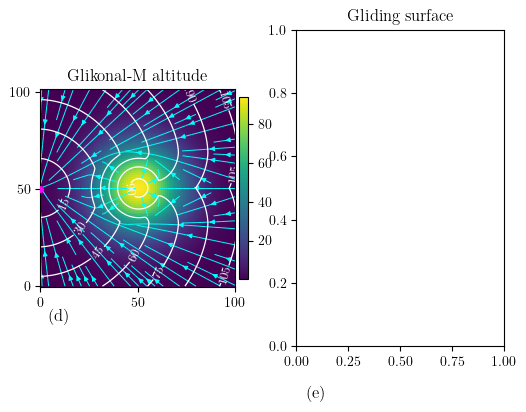

In [10]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True})

fig,axes=plt.subplots(1,2,figsize=(5.2,3.6))

fig.tight_layout(pad=0.6)


ax=axes[0]
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
pc2=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.84,color='aqua',linewidth=0.7,arrowsize=0.7)

CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.9)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='magenta',label='aircraft',zorder=10000,s=16)
fig.colorbar(pc,ax=ax,fraction=0.044, pad=0.02)

grid2[grid2==-np.inf]=0
grid2[grid2>0]=np.inf
grid2[0,0]=1

colors = [(1-c,0,0,1) for c in np.linspace(0,1,100)]# Create the colormap
cmap_name = 'red_to_black'
n_bins = 100  # Number of bins (discrete color levels)
cmap_red = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
pc2=ax.pcolormesh(X,Y,grid2,cmap=cmap_red,shading='nearest',alpha=0.4)
ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.set_xlim([0,100])
ax.set_title('Glikonal-M altitude')
ax.text(0.1, -0.15, "(d)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax=axes[1]
ax.set_title("Gliding surface")
ax.text(0.1, -0.15, "(e)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
#axes[2].remove()
plt.savefig("pics/glikonal_mrap_single_peak.pdf", bbox_inches='tight', dpi=600)

## More realistic looking mountein range with two saddles

In [11]:
H=101 
W=101

h=1
hy=h
hx=h


center=(H//2,W//2)
xx,yy=np.meshgrid(np.arange(0,W,hx,dtype=np.intc),np.arange(0,H,hy,dtype=np.intc))
peak_x=50
elevation_profile=75*np.exp(-(xx-peak_x)**2/80)
saddle_1_y=20
saddle_1_strength=30 #the higher the strength the lower the top of the saddle
saddle_2_y=80
saddle_2_strength=35
elevation=np.maximum(0,elevation_profile-saddle_1_strength*np.exp(-(yy-saddle_1_y)**2/17)-saddle_2_strength*np.exp(-(yy-saddle_2_y)**2/17))+1
center=(75,80)
xx,yy=np.meshgrid(np.arange(0,H,hy,dtype=np.intc),np.arange(0,W,hx,dtype=np.intc))
elevation=elevation+50*np.exp(-(6*(xx-center[1])**2+(yy-center[0])**2)/400) #set the elevation profile
elevation=elevation[:,::-1]


#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=0

In [12]:
radius=2.9 
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
grid=mrap.FMM_MRAP(init_nodes, init_values, elevation, h,g,H,W)
grid_chars=np.moveaxis(np.array(np.gradient(grid)),0,2)
grid_chars=-np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))
#grid=np.maximum(grid,np.zeros_like(grid))

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60749/22309623.py:5: RuntimeWarning: divide by zero encountered in divide
  grid_chars=-np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))


In [13]:
grid=np.maximum(grid,np.zeros_like(grid))
grid2=np.copy(grid)
grid[grid==0]=np.nan
# Create the first surface
surf1 = pv.StructuredGrid(X, Y, elevation)
surf1['elevation'] = elevation.T.flatten()

# Create the second surface
surf2 = pv.StructuredGrid(X, Y, grid+0.1)
surf2_shift = pv.StructuredGrid(X, Y, grid+0.2)# perturbing to avoid overlapping surfaces (visual artifacts)

surf2['elevation'] = grid.T.flatten()
surf2_shift['elevation'] = (grid).T.flatten()


point=[hx*init_pos[1],hy*init_pos[0],init_altitude]
point_cloud = pv.PolyData(point)
contours_alt = surf2_shift.contour()

# Plot the surfaces
plotter = pv.Plotter()
plotter.enable_anti_aliasing('msaa', multi_samples=16)

plotter.add_mesh(surf2, color='orange',cmap='viridis', opacity=0.7)
plotter.add_mesh(surf1, opacity=1,cmap='viridis',show_scalar_bar=False)
plotter.add_mesh(contours_alt, color="white", line_width=3)
plotter.add_mesh(point_cloud, color='magenta', point_size=10)

# Show the plot
plotter.show()
plotter.save_graphic("pics/mountain_range_3d_mrap.pdf",raster=False)

/Users/piccioli/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pyvista/core/utilities/points.py:52: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:62109/index.html?ui=P_0x7fcc7183d9a0_1&reconnect=auto" class="pyvi…

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60749/2201800297.py:20: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.7)


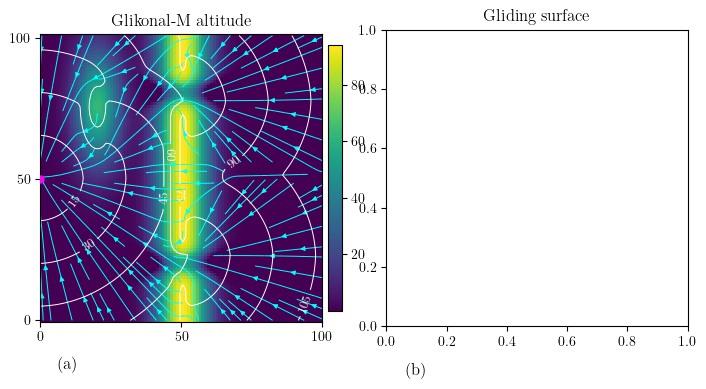

In [14]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True})

fig,axes=plt.subplots(1,2,figsize=(7,3.4))

fig.tight_layout(pad=0.6)

ax=axes[0]

X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
pc2=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.94,color='aqua',linewidth=0.7,arrowsize=0.7)

CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.7)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='magenta',label='glider',zorder=10000,s=25)
#fig.colorbar(pc,ax=ax,fraction=0.044, pad=0.02)

grid2[grid2==-np.inf]=0
grid2[grid2>0]=np.inf
grid2[0,0]=1

ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.set_xlim([0,100])
ax.set_title('Glikonal-M altitude')
ax.text(0.1, -0.15, "(a)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
fig.colorbar(pc,ax=ax,fraction=0.044, pad=0.02)

ax=axes[1]
ax.set_title("Gliding surface")
ax.text(0.1, -0.15, "(b)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
#axes[2].remove()
plt.savefig("pics/glikonal_mrap_mountauin_range.pdf", bbox_inches='tight', dpi=600)

### This last plot is to show the different trajectories of GRRP and MRAP.
 To produce the plot MRAP is used in both scenarios. However the point here is to just produce the plot, not to demonstrate the trajectory algorithmically. The reader shoudl content itself with the mathematical proof and see the following as a mean to produce an illustration. 

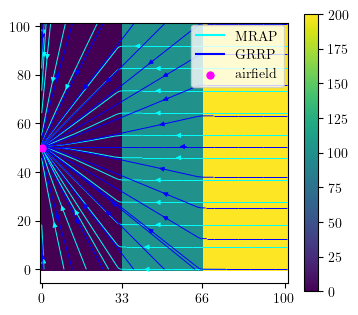

In [15]:
H=101 
W=101
g=1
h=1
hx=hy=h
init_altitude=0
elevation=0*np.ones([H,W]) #set the elevation profile
#elevation[:,:33]=0
#elevation[:,33:66]=0
elevation[:,66:]=200
init_pos=(H//2,0) #source position
radius=2.9 
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
grid=mrap.FMM_MRAP(init_nodes, init_values, elevation, h,g,H,W)
grid_chars=np.moveaxis(np.array(np.gradient(grid)),0,2)
grid_chars2=-np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))
elevation[:,33:66]=100
radius=2.9 
init_pos=(H//2,0) #source position
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
grid=mrap.FMM_MRAP(init_nodes, init_values, elevation, h,g,H,W)
grid_chars=np.moveaxis(np.array(np.gradient(grid)),0,2)
grid_chars=-np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True})
fig,ax=plt.subplots(figsize=(4,3.6))
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
pc2=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.4,color='aqua',linewidth=0.7,arrowsize=0.7,broken_streamlines=False)
ax.streamplot(X,Y,grid_chars2[:,:,1],grid_chars2[:,:,0],density=0.3,color='blue',linewidth=0.7,arrowsize=0.7,broken_streamlines=False)
ax.plot([0,0],[0,0],color='aqua',label='MRAP')
ax.plot([0,0],[0,0],color='blue',label='GRRP')
ax.set_xticks([0,33,66,100])
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='magenta',label='airfield',zorder=10000,s=25)
ax.set_aspect('equal')

plt.colorbar(pc2)
fig.legend(bbox_to_anchor=(0.75, 0.87))
#plt.savefig("pics/grrp_mrap_difference.pdf", bbox_inches='tight', dpi=600)